# 介绍：

In [ ]:
某公司2019年的游戏安全数据分析竞赛

数据背景：
该游戏是个MOBA类型的游戏，有每个选手的每场比赛表现流水，目的是为了从这些比赛流水中找出代练账户
conseq为战绩流水，doing是比赛中的行为流水

注：
1.由于原本的数据量过大（电脑跑不动），在这里分析的数据是原来的1/10，并且为了提高运行速度已经由csv转换为了npy格式
2.doing数据表示玩家在比赛中的行为流水，conseq数据表示玩家在比赛中的战绩流水
3.关于拟合模型的指标：
    分析label的两个值各占比例，可以看出这是个高度不对称数据，为1的样本量仅占11%左右。
    因此不适合用分类正确率来作为判断结果的参考，因为傻瓜分类器也能分类正确率高达89%
    根据题目要求要找到所谓“代练账户”，我认为召回率（所有真实显著样本中被检查出显著的样本数量/所有真实显著样本数量）越高越好
    假阳性率越低越好（即真实不显著样本数量/所有被检验出显著的样本数量）
    因此使用roc这一指标,照顾了这两者(通常假阳性和召回率同增同减,我希望前者小后者大,比如说检验越松散,往往召回率越高,但是假阳性比例也会越高)
    通常roc是越高越好，最大为1，超过0.8则不错了
    这题，傻瓜分类器全部预测为0，虽然正确率高达89%，但是召回率只有0
4.官方的评分标准是：计算得分score=4PR/(P+3R)*100%，其中P为测试集预测结果整体的准确度，R表示测试集预测结果被判为代练的玩家在真实代练玩家中的覆盖度（召回率）
   要求召回率越高越好，同时假阳性率越低越好，因为不能把没开挂的人误封，这样非常不妥。

提取的特征：
思路：（可视化提取）
面对这么多统计量，并不是全部都保留，而是看它们在不同label下的直方图是否相同，差距是否很大，如果差距很大说明这个特征可能有一定作用。

最终结果显示比较重要的特征：
    随机森林显示，重要的特征依次是：
        该玩家在所有比赛中的平均排名，英雄熟练度的最大值，游戏对局时长最大值，对局评价分最大值，所有局中造成的魔法伤害最大值
    根据xgb的plot_importance判断特征重要性(降序，只列出了10个)：
        该玩家在所有比赛中的平均排名，英雄熟练度的最大值，游戏对局时长最大值，对局评价分最大值，击杀数量中位数，
        造成魔法伤害的极差，最大连杀次数的最大值，游戏时长的极差，造成魔法伤害的最大值，击杀数量的极差


待提升空间：
本次分析没有对提取后的数据进行各种encode操作，没有使用全部的数据，也没有使用模型融合或者调参等技术，
没有对两个16进制的特征进行好好利用（解码）。

In [ ]:
总结：
1.本次项目的难点主要在于数据全是时间序列数据，需要有效的特征提取
2.模型在只有1/10的数据，以及没有使用时间型数据以及没有任何调参的情况下获得了0.83左右的AUC，效果还可以
3.提取特征时，面对许多数值型特征的许多统计量，不一定要全部都提取。
  考虑在label不同的情况下该统计量的分布区别越大的特征越有提取的意义（说明该特征分类能力强）

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据和给列命名

In [ ]:
data_conseq = np.load("data_conseq.npy",allow_pickle = True)
data_conseq = pd.DataFrame(data_conseq)
data_doing = np.load("data_doing.npy",allow_pickle = True)
data_doing = pd.DataFrame(data_doing)

#读取列名表格，conseq列为战绩流水列名，doing为行为流水列名
cn2 = pd.read_csv("col_name.csv",header = 0)
data_conseq.columns = cn2["conseq"].dropna().values
data_doing.columns = cn2["doing"].values

In [13]:
data_conseq.head()

,uid,worldid,game_id,game_mode,battle_time,champion_id,team,champions_killed,num_deaths,assists,killing_spress,game_score,flag,ext_flag,champion_used_exp
0,53441893,75,1123320262,4,2019-02-26 18:16:19,53,100,4,1,5,2,1290,8,256,21965
1,53441893,75,1123339985,4,2019-02-26 20:49:07,59,200,8,5,22,3,1290,16,0,19212
2,53441893,75,1123594658,4,2019-02-27 18:37:56,86,200,4,2,4,1,1010,0,1048832,19632
3,53441893,75,1123613112,4,2019-02-27 18:10:09,17,200,8,0,1,1,1270,1,1982720,26778
4,53441893,75,1123665332,4,2019-02-27 21:12:45,64,200,2,6,7,0,670,24,0,20539


In [14]:
data_doing.head()

,uid,worldid,game_id,dtEvnetTime,dtGameStartTime,iMapID,iDuration,iBasegamemode,iSubgamemode,iExpChange,...,iTimeSpentDead,iTurretsDestroyed,iSpell1,iSpell2,Summoner_level,Champion_id,Predicted_win,Premade,Premade_size,Elo_change
0,4007318390,74,541101244,2019-03-04 06:28:04,2019-03-04 06:05:32,11,1352,1,4,0,...,35,2,4,14,172,91,0.52301,false,1,12
1,2928536459,82,1499793258,2019-03-02 05:40:19,2019-03-02 05:05:02,11,2117,1,4,0,...,316,0,4,14,129,99,0.52301,false,2,-13
2,2945527479,84,1542251694,2019-03-06 12:31:01,2019-03-06 11:59:17,11,1904,1,4,0,...,178,0,4,7,218,40,0.528751,false,1,12
3,2953484894,90,1297110042,2019-03-02 16:40:50,2019-03-02 16:11:05,11,1785,1,4,0,...,236,1,4,7,33,67,0.475555,false,1,-12
4,2959141576,98,2706982848,2019-03-03 13:19:43,2019-03-03 12:52:03,11,1660,1,4,0,...,235,2,4,14,174,517,0.525881,false,1,12


In [15]:
#为id列命名
train_id = np.load("train_id.npy",allow_pickle = True)
train_id = pd.DataFrame(train_id)
train_id.columns = ['uid',"worldid","label"]

test_id = np.load("test_id.npy",allow_pickle = True)
test_id = pd.DataFrame(test_id)
test_id.columns = ['uid',"worldid"]

In [16]:
train_id.head()

,uid,worldid,label
0,4016310399,69,0
1,4016310949,69,1
2,4016311184,69,1
3,4016311766,69,1
4,4016311933,69,0


In [17]:
train_id.shape

(121684, 3)

In [18]:
test_id.head()

,uid,worldid
0,4016310262,69
1,4016319171,69
2,4016319442,69
3,4016321122,69
4,4016322431,69


In [19]:
test_id.shape

(10000, 2)

In [20]:
#删除doing的一些无用列
#判断为无用列的标准：所有样本的该值都相等，没有变化
data_doing = data_doing.drop(columns = ["iMapID","iBasegamemode","iExpChange","iSubgamemode","Premade"],axis = 1)

In [21]:
#删除conseq的一些无用列(所有样本的该值都相等)
data_conseq = data_conseq.drop(columns = ["game_mode"],axis = 1)

# 合并doing和conseq表格，根据三个key：uid，worldid，game_id

In [71]:
%%time
all_data = pd.merge(data_doing,data_conseq,how="inner",on = ['uid',"worldid","game_id"])
print()


Wall time: 10.9 s


In [72]:
all_data.head()

,uid,worldid,game_id,dtEvnetTime,dtGameStartTime,iDuration,iExpTotal,iMoneyTotal,iMoneyChange,iRankInGame,...,champion_id,team,champions_killed,num_deaths,assists,killing_spress,game_score,flag,ext_flag,champion_used_exp
0,4007318390,74,541101244,2019-03-04 06:28:04,2019-03-04 06:05:32,1352,2314,0,58393,1150,...,91,200,10,3,5,2,850,0,1048832,18238
1,2928536459,82,1499793258,2019-03-02 05:40:19,2019-03-02 05:05:02,2117,423,0,11703,1138,...,99,200,6,12,14,1,770,16,512,9908
2,2945527479,84,1542251694,2019-03-06 12:31:01,2019-03-06 11:59:17,1904,1636,0,240813,1232,...,40,200,1,6,19,0,470,16,66560,15438
3,2953484894,90,1297110042,2019-03-02 16:40:50,2019-03-02 16:11:05,1785,2092,0,2107,1067,...,67,100,6,9,5,2,770,28,2097668,7804
4,2959141576,98,2706982848,2019-03-03 13:19:43,2019-03-03 12:52:03,1660,2149,0,21834,1519,...,517,200,3,8,9,1,800,16,0,15458


# 合并train_id和all_data

In [78]:
#合并train_id
da_withtr = pd.merge(all_data,train_id,how = "inner",on = ["uid","worldid"])

In [79]:
train_id.shape

(121684, 3)

In [80]:
#da_withtr的行数远远多于train_id的行数，所以可以很明显看出，一个id有多场比赛
da_withtr.shape

(337397, 44)

In [ ]:
#指定列，该列有na的就删了对应行
da_withtr = da_withtr.dropna(subset = ["dtGameStartTime"])

In [83]:
da_withtr.shape #此时的样本量已经变得和data_doing一样

(337397, 44)

# 处datetime特征列

In [88]:
da_withtr["dtEvnetTime"] = pd.to_datetime(da_withtr["dtEvnetTime"],format = "%Y-%m-%d %H:%M:%S")
da_withtr["dtGameStartTime"] = pd.to_datetime(da_withtr["dtGameStartTime"],format = "%Y-%m-%d %H:%M:%S")
#battle_time指的是对局开始时间，比dtGameStartTime一般略早一点
da_withtr["battle_time"] = pd.to_datetime(da_withtr["battle_time"],format = "%Y-%m-%d %H:%M:%S")

In [99]:
da_withtr.loc[(da_withtr["dtGameStartTime"].dt.month==3) & (da_withtr["dtGameStartTime"].dt.day>=7)]["dtGameStartTime"]
#最远的游戏时间记录就是在3月7日

9        2019-03-07 14:40:05
11       2019-03-07 04:14:44
13       2019-03-07 09:42:16
18       2019-03-07 11:25:30
30       2019-03-07 12:11:53
                 ...        
337383   2019-03-07 00:11:14
337387   2019-03-07 13:56:05
337388   2019-03-07 20:59:58
337391   2019-03-07 15:46:10
337396   2019-03-07 21:36:10
Name: dtGameStartTime, Length: 61680, dtype: datetime64[ns]

# 提取特征

In [ ]:
game_data = da_withtr.copy()

In [4]:
#champion_id和Champion_id重复，只保留一个即可
game_data = game_data.drop(columns = ["Champion_id"],axis = 1)[:] 

#iMoney_Total全是0，删除
game_data = game_data.drop(columns = ["iMoneyTotal"],axis = 1)[:]

In [5]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337397 entries, 0 to 337396
Data columns (total 42 columns):
uid                       337397 non-null int64
worldid                   337397 non-null int64
game_id                   337397 non-null int64
dtEvnetTime               337397 non-null datetime64[ns]
dtGameStartTime           337397 non-null datetime64[ns]
iDuration                 337397 non-null int64
iExpTotal                 337397 non-null int64
iMoneyChange              337397 non-null int64
iRankInGame               337397 non-null int64
iLeaver                   337397 non-null int64
iDamgeDealt               337397 non-null int64
iDamageTaken              337397 non-null int64
iGoldEarned               337397 non-null int64
iHealingDone              337397 non-null int64
iLargestKillingSpree      337397 non-null int64
iLargestMultiKill         337397 non-null int64
iMagicDamageDealt         337397 non-null int64
iMagicDamageTaken         337397 non-null int64
iMinion

In [66]:
#team特征比较复杂，同个数值代表同个team，需要是同一场比赛
game_data["team"]

0         200
1         200
2         200
3         100
4         200
         ... 
337392    200
337393    200
337394    200
337395    100
337396    200
Name: team, Length: 337397, dtype: int64

In [6]:
#id特征
id_att = ["uid","worldid","game_id"]

#数值型特征
num_att = ["champions_killed","num_deaths","assists","game_score","champion_used_exp",
          "iDuration","iExpTotal","iMoneyChange","iRankInGame",
          "iDamgeDealt","iDamageTaken","iGoldEarned","iHealingDone","iLargestKillingSpree",
          "iMagicDamageDealt","iMagicDamageTaken","iMinionsKilled","iNeutralMonsterKills","iPhysical Damage Dealt",
          "iPhysicalDamageTaken","iTimeSpentDead"]

#分类特征
cat_att = ["champion_id","team","iLeaver","iSpell1","iSpell2","killing_spress","iLargestMultiKill","iTurretsDestroyed"]

#难以分析的特征，需要由16进制转回2进制？但是又不能理解类型太多和题目提供的不符合，可能需要解码（被加密了）
complex_att_0x = ["flag","ext_flag"]

#日期型特征
date_att = list(game_data.select_dtypes(include = ["datetime64[ns]"]).columns)

#目标特征，0表示非代练，1表示代练
y_att = ["label"]

# 可视化观察

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B685270388>,
      dtype=object)

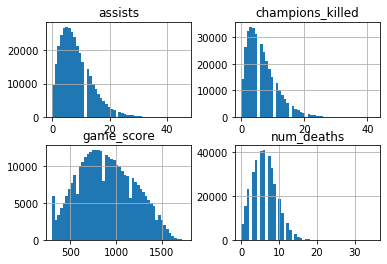

In [79]:
game_data[num_att[0:4]].hist(bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B6851BE688>,
      dtype=object)

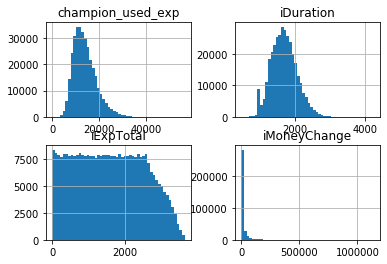

In [80]:
game_data[num_att[4:8]].hist(bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B685739C88>,
      dtype=object)

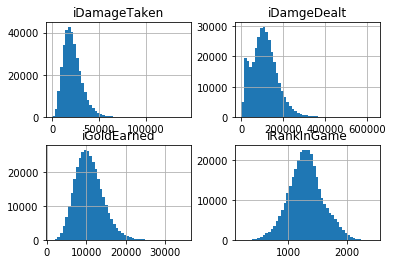

In [81]:
game_data[num_att[8:12]].hist(bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B69E66F388>,
      dtype=object)

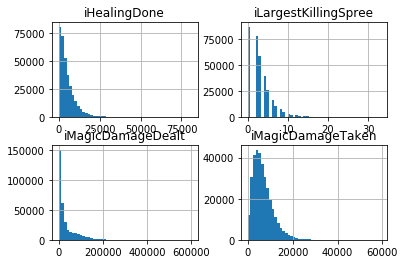

In [82]:
game_data[num_att[12:16]].hist(bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B69E877588>,
      dtype=object)

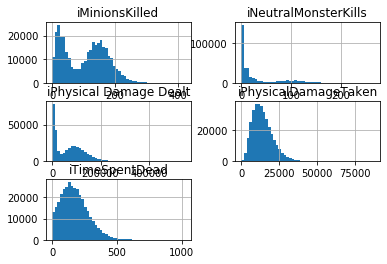

In [83]:
game_data[num_att[16:]].hist(bins = 50)

# 观察代练账户和非代练账号的数据

In [ ]:
#什么是代练账号：
#高水平玩家通过（代练）平台接单，使用被代练玩家的账号打段位赛升级，这个账号就是代练账号

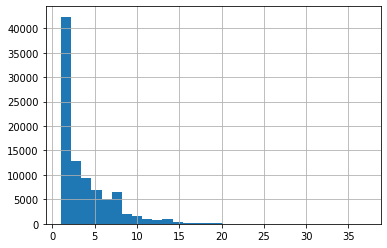

In [16]:
#大部分人的比赛次数只有1~3场，超过这个数字的就很少了
game_data["game_score"].groupby([game_data["uid"],game_data["worldid"]]).count().hist(bins=30)

In [42]:
#可以看到:大部分人的比赛次数只有1~3场，超过这个数字的就很少了
game_data["game_score"].groupby([game_data["uid"],game_data["worldid"]]).count().value_counts()

1     24645
2     17723
3     12862
4      9469
5      6886
6      5032
7      3720
8      2732
9      2034
10     1570
11     1083
12      743
13      594
14      406
15      335
16      220
17      172
18      124
19      103
20       57
21       47
22       26
23       20
24       17
27        7
25        6
28        6
26        4
29        4
34        1
30        1
32        1
37        1
Name: game_score, dtype: int64

In [7]:
#找出打了k场游戏那些人的uid和game_id
def check_game_times(k = 24):
    x = []
    for i,val in enumerate((game_data["game_score"].groupby([game_data["uid"],game_data["worldid"]]).count()==k).values):
        if val == True:
            x.append(i)
    return x

In [8]:
#随便看看，比如说看看打了24场排位的那17人是什么情况
t = check_game_times(k = 24)

In [8]:
df_24 = pd.DataFrame()
indexes = game_data["game_score"].groupby([game_data["uid"],game_data["worldid"]]).count()[t].index
for index in indexes:
    df_24 = df_24.append(game_data[(game_data["uid"] == index[0])&(game_data["worldid"]==index[1])][id_att+cat_att+y_att])

In [10]:
df_24.head()

,uid,worldid,game_id,champion_id,team,iLeaver,iSpell1,iSpell2,killing_spress,iLargestMultiKill,iTurretsDestroyed,label
53131,2927731496,86,3750405051,157,200,0,4,14,4,2,0,0
53132,2927731496,86,3749185060,157,200,0,4,14,3,1,0,0
53133,2927731496,86,3767274498,64,200,0,4,11,1,1,1,0
53134,2927731496,86,3748925287,64,100,0,4,11,1,1,0,0
53135,2927731496,86,3752564752,59,200,0,4,11,3,2,1,0


In [69]:
df_24[df_24["label"] == 0]["iLeaver"].value_counts()

0    336
Name: iLeaver, dtype: int64

In [72]:
df_24[df_24["label"] == 1]["iLeaver"].value_counts()

0    72
Name: iLeaver, dtype: int64

# 将label为1的聚集到一起，label为0的聚集到一起，分别看看他们的不同

思路：看它们的直方图是否相同，差距是否很大，如果差距很大说明这个特征可能有一定作用

注：这里只给出了iLargestMultiKill的部分统计量提取作为例子，其余均省略，直接跳到最终提取结果

***先看分类特征***

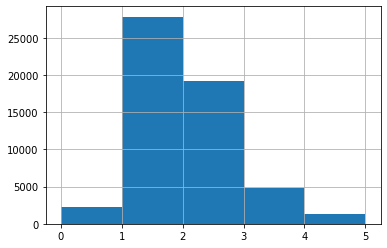

In [77]:
game_data[game_data["label"]==1]["iLargestMultiKill"].hist(bins = 5)

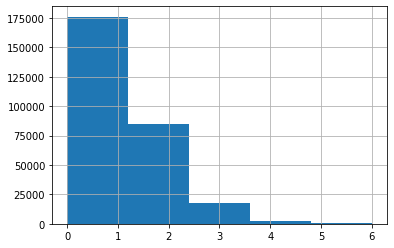

In [78]:
game_data[game_data["label"]==0]["iLargestMultiKill"].hist(bins = 5)

In [19]:
sum_label_0 = game_data[game_data["label"]==0].shape[0]
game_data[game_data["label"]==0]["iLargestMultiKill"].value_counts().sort_index()/sum_label_0

0    0.043362
1    0.581256
2    0.301341
3    0.061854
4    0.009888
5    0.002295
6    0.000004
Name: iLargestMultiKill, dtype: float64

In [18]:
sum_label_1 = game_data[game_data["label"]==1].shape[0]
game_data[game_data["label"]==1]["iLargestMultiKill"].value_counts().sort_index()/sum_label_1

0    0.040419
1    0.502615
2    0.346458
3    0.087854
4    0.017784
5    0.004870
Name: iLargestMultiKill, dtype: float64

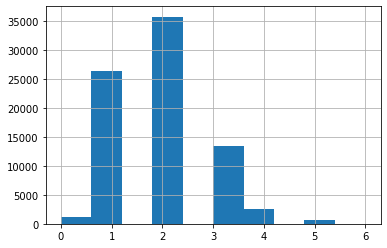

In [71]:
game_data[game_data["label"]==0][id_att+["iLargestMultiKill"]].groupby([game_data["uid"],game_data["worldid"]]).max()\
["iLargestMultiKill"].hist(bins = 10)

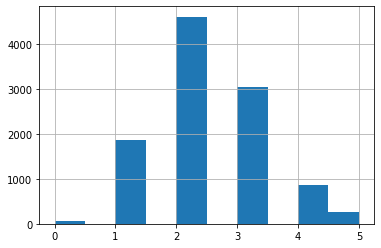

In [72]:
game_data[game_data["label"]==1][id_att+["iLargestMultiKill"]].groupby([game_data["uid"],game_data["worldid"]]).max()\
["iLargestMultiKill"].hist(bins = 10)

值的一看的类别特征只有iLargestMultiKill特征,其他类别特征的直方图都类似

准备提取的特征：

1.最大连杀次数的最大值 2.某选手3次或者4次及以上最大连杀次数占总比赛数目的比例；

数值型特征

In [11]:
num_att[20:]

['iTimeSpentDead']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000263A06BA148>]],
      dtype=object)

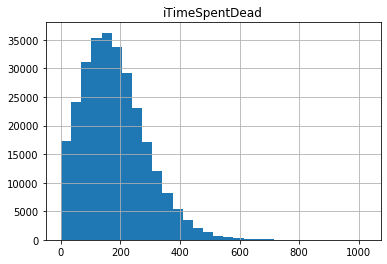

In [10]:
game_data[game_data["label"]== 0][num_att[20:]].hist(bins = 30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FFD26288C8>]],
      dtype=object)

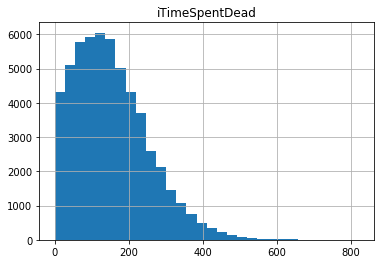

In [50]:
game_data[game_data["label"]== 1][num_att[20:]].hist(bins = 30)

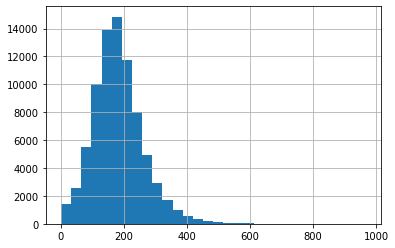

In [57]:
game_data[game_data["label"]==0][id_att+["iTimeSpentDead"]].groupby([game_data["uid"],game_data["worldid"]]).mean()\
["iTimeSpentDead"].hist(bins = 30)

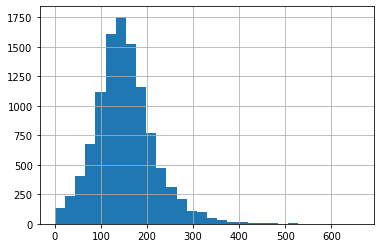

In [58]:
game_data[game_data["label"]==1][id_att+["iTimeSpentDead"]].groupby([game_data["uid"],game_data["worldid"]]).mean()\
["iTimeSpentDead"].hist(bins = 30)

In [19]:
#补充统计量：某个特征在某个账号下的极差（最大值减去最小值）
#ctr即为count the range的缩写
def ctr(data = game_data,att = "game_score",label = 0):
    max_val = data[data["label"]==label][id_att+[att]].groupby([data["uid"],data["worldid"]]).max()
    min_val = data[data["label"]==label][id_att+[att]].groupby([data["uid"],data["worldid"]]).min()
    rge = max_val - min_val
    return rge

def ctr2(data = game_data,att = "game_score"):
    max_val = data.groupby([data["uid"],data["worldid"]]).max()[att]
    min_val = data.groupby([data["uid"],data["worldid"]]).min()[att]
    rge = max_val - min_val
    return rge

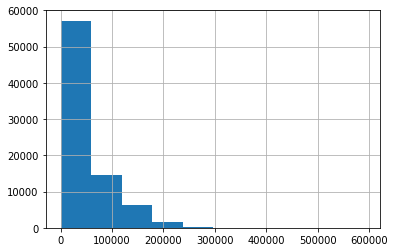

In [58]:
ctr(att = "iMagicDamageDealt")["iMagicDamageDealt"].hist()

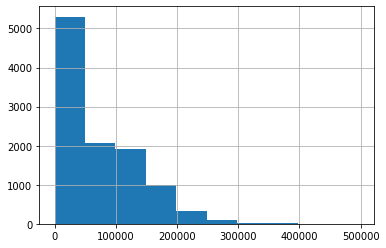

In [59]:
ctr(att = "iMagicDamageDealt",label = 1)["iMagicDamageDealt"].hist()

In [ ]:
#备注，还差一个特征：某选手3次或者4次及以上iLargestMultiKill占总比赛数目的比例；

In [12]:
#需要简单统计量的特征
need_max_att = ["game_score","num_deaths","iLargestMultiKill","champion_used_exp","iLargestKillingSpree","iMagicDamageDealt"]
need_median_att  = ["champions_killed"]
need_min_att = ["champions_killed","iDuration"]
need_mean_att = ["iExpTotal","iRankInGame"]
need_std_att = ["iDuration"]

#稍微复杂一点的统计量，如极差
#这类特征主要是从简单统计量的特征里面找的，没有选进简单统计量的特征暂时没有考虑
need_range_att = ["game_score","num_deaths","iLargestMultiKill","iMagicDamageDealt","champions_killed","iDuration","iExpTotal"]

***开始提取特征...***

In [13]:
max_df = game_data.groupby([game_data["uid"],game_data["worldid"]]).max()[need_max_att]

new_name = []
for name in need_max_att:
    new_name.append(name+"_max")

max_df.columns = new_name

In [14]:
median_df = game_data.groupby([game_data["uid"],game_data["worldid"]]).median()[need_median_att]

new_name = []
for name in need_median_att:
    new_name.append(name+"_median")
    
median_df.columns = new_name

In [15]:
min_df = game_data.groupby([game_data["uid"],game_data["worldid"]]).min()[need_min_att]

new_name = []
for name in need_min_att:
    new_name.append(name+"_min")
    
min_df.columns = new_name

In [16]:
mean_df = game_data.groupby([game_data["uid"],game_data["worldid"]]).mean()[need_mean_att]

new_name = []
for name in need_mean_att:
    new_name.append(name+"_mean")
    
mean_df.columns = new_name

In [17]:
std_df = game_data.groupby([game_data["uid"],game_data["worldid"]]).std()[need_std_att]

new_name = []
for name in need_std_att:
    new_name.append(name+"_std")
    
std_df.columns = new_name

In [20]:
range_df = pd.DataFrame()

for i in range(len(need_range_att)):
    df_temp = pd.DataFrame(ctr2(att = need_range_att[i]))
    range_df = pd.concat([range_df,df_temp],axis = 1)[:]

new_name = []
for name in need_range_att:
    new_name.append(name+"_range")
    
range_df.columns = new_name

In [21]:
all_need_att = pd.concat([max_df,median_df,min_df,mean_df,std_df,range_df],axis =1)[:]

In [22]:
all_need_att.head()

,,game_score_max,num_deaths_max,iLargestMultiKill_max,champion_used_exp_max,iLargestKillingSpree_max,iMagicDamageDealt_max,champions_killed_median,champions_killed_min,iDuration_min,iExpTotal_mean,iRankInGame_mean,iDuration_std,game_score_range,num_deaths_range,iLargestMultiKill_range,iMagicDamageDealt_range,champions_killed_range,iDuration_range,iExpTotal_range
uid,worldid,,,,,,,,,,,,,,,,,,,
53441893,75,1010,5,1,26776,4,24954,4.0,0,946,1572.666667,1460.000000,331.161592,540,3,1,18663,5,630,1541
53499839,73,1170,8,2,25393,5,7580,10.5,7,1415,1873.000000,1557.000000,317.490945,320,4,1,6916,7,449,108
53509485,75,1460,11,2,16951,7,146412,6.0,2,1462,1257.000000,1001.750000,280.119745,810,8,1,140875,9,720,2900
53547389,75,1260,8,2,16492,6,141425,2.0,0,1379,1519.000000,1323.800000,251.848566,860,7,2,125988,16,637,2590
53556293,73,1380,11,2,28230,4,120535,4.0,0,929,1500.714286,1589.214286,327.765336,1080,11,2,118943,13,1258,2485


In [25]:
#获取label的值
label_att = game_data[["uid","worldid","label"]].drop_duplicates()

In [26]:
#将label和特征数据集连接，准备开始建模
prepare_data = pd.merge(label_att,all_need_att,how = "inner",left_on =["uid","worldid"],right_index = True)[:]

# 尝试用gbdt观察效果

***注：这里只是简单地建立模型，没有通过各种融合还有调参***

In [4]:
#此处为读取数据不需要运行
#prepare_data = pd.read_csv("prepare_data.csv").iloc[:,1:]

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [6]:
#先不使用iDuration_std
X = prepare_data.drop(columns = ["uid","worldid","label","iDuration_std"]).copy()
y = prepare_data[["label"]].copy()

In [7]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [177]:
gbdt = GradientBoostingClassifier(random_state = 42)
gbdt.fit(X_train,y_train)

E:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [178]:
y_prob_gbdt = gbdt.predict_proba(X_val)[:,1]
roc_auc_score(y_val,y_prob_gbdt)

0.8265317774516422

In [180]:
#使用iDuration_std,这里NA值填充为0，因为NA是因为该账号只有一场比赛，标准差就是0
X2 = prepare_data.drop(columns = ["uid","worldid","label"]).copy().fillna(0)
y2 = prepare_data[["label"]].copy()

In [181]:
X_train2,X_val2,y_train2,y_val2 = train_test_split(X2,y2,test_size = 0.2,random_state = 42)

In [182]:
gbdt2 = GradientBoostingClassifier(random_state = 42)
gbdt2.fit(X_train2,y_train2)

E:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [183]:
y_prob_gbdt2 = gbdt2.predict_proba(X_val2)[:,1]
roc_auc_score(y_val2,y_prob_gbdt2)

0.8276026393646331

In [88]:
#尝试用随机森林观察特征重要性
from sklearn.ensemble import RandomForestClassifier

X3 = prepare_data.drop(columns = ["uid","worldid","label"]).copy()
y3 = prepare_data[["label"]].copy()

X3 = X3.fillna(-999)

rf = RandomForestClassifier(random_state =42)
rf.fit(X3,y3)

E:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

([<matplotlib.axis.XTick at 0x2639cbdd608>,
 <a list of 19 Text xticklabel objects>)

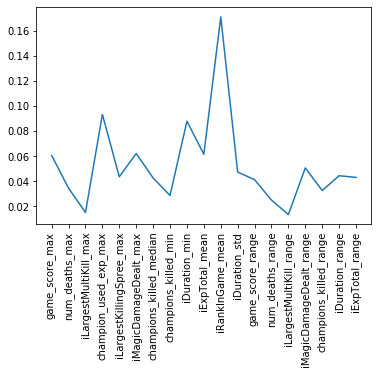

In [89]:
import matplotlib.pyplot as plt
plt.plot(rf.feature_importances_)
plt.xticks(np.arange(X3.shape[1]),X3.columns.tolist(), rotation=90)

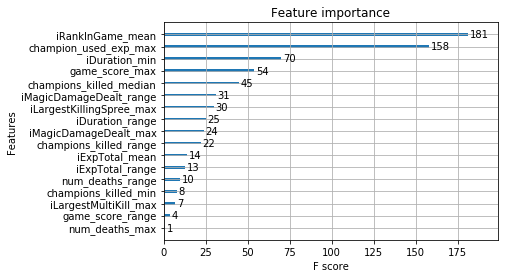

In [10]:
from xgboost import XGBClassifier,plot_importance
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train,y_train)
plot_importance(xgb,max_num_features = 20)

# 研究datetime相关的特征

In [106]:
prepare_data

,uid,worldid,label,game_score_max,num_deaths_max,iLargestMultiKill_max,champion_used_exp_max,iLargestKillingSpree_max,iMagicDamageDealt_max,champions_killed_median,...,iExpTotal_mean,iRankInGame_mean,iDuration_std,game_score_range,num_deaths_range,iLargestMultiKill_range,iMagicDamageDealt_range,champions_killed_range,iDuration_range,iExpTotal_range
0,2928536459,82,0,1310,12,3,19026,7,72067,6.0,...,1546.857143,1166.190476,426.327797,830,9,2,67876,15,1385,2595
1,2945527479,84,0,1090,9,2,19394,3,75287,3.0,...,1959.000000,1246.750000,318.223585,640,6,1,64535,5,758,1417
2,2953484894,90,0,770,9,2,7804,2,498,6.0,...,2092.000000,1067.000000,NaN,0,0,0,0,0,0,0
3,2959141576,98,0,1370,10,2,20295,5,139081,2.0,...,1056.352941,1476.941176,351.998851,1070,10,2,139081,13,1247,2296
4,4005924015,93,1,1330,14,2,13323,5,129842,5.5,...,1702.000000,1518.600000,284.222546,800,13,2,127225,11,989,2755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90646,2930606436,91,0,880,12,2,24293,3,5096,11.0,...,744.000000,1534.000000,NaN,0,0,0,0,0,0,0
90647,4009183319,94,0,480,8,2,12858,4,11095,5.0,...,1209.000000,990.000000,NaN,0,0,0,0,0,0,0
90648,4041638739,86,0,1080,6,1,8688,3,9047,12.0,...,897.000000,1342.000000,NaN,0,0,0,0,0,0,0
90649,4135119484,99,0,720,5,0,5931,0,41901,0.0,...,1399.000000,969.000000,NaN,0,0,0,0,0,0,0


In [108]:
game_data[id_att+date_att]

,uid,worldid,game_id,dtEvnetTime,dtGameStartTime,battle_time
0,2928536459,82,1499793258,2019-03-02 05:40:19,2019-03-02 05:05:02,2019-03-02 05:03:57
1,2928536459,82,1498817225,2019-02-27 21:02:48,2019-02-27 20:27:11,2019-02-27 20:22:59
2,2928536459,82,1499301410,2019-03-01 02:30:52,2019-03-01 02:08:30,2019-03-01 02:06:03
3,2928536459,82,1501289868,2019-03-04 23:19:01,2019-03-04 22:45:45,2019-03-04 22:43:18
4,2928536459,82,1501252484,2019-03-04 20:34:36,2019-03-04 20:10:02,2019-03-04 20:08:29
...,...,...,...,...,...,...
337392,2930606436,91,1958217128,2019-03-02 16:37:28,2019-03-02 16:06:02,2019-03-02 16:05:04
337393,4009183319,94,3176710501,2019-03-02 02:37:43,2019-03-02 02:18:14,2019-03-02 02:17:13
337394,4041638739,86,3756719381,2019-03-03 02:37:59,2019-03-03 02:08:28,2019-03-03 02:06:38
337395,4135119484,99,3863047771,2019-03-01 23:11:38,2019-03-01 22:38:56,2019-03-01 22:36:49


In [ ]:
prepare_data["battle_time"] = pd.to_datetime(prepare_data["battle_time"],format = "%Y-%m-%d %H:%M:%S")
prepare_data["dtEvnetTime"] = pd.to_datetime(prepare_data["dtEvnetTime"],format = "%Y-%m-%d %H:%M:%S")
prepare_data["dtGameStartTime"] = pd.to_datetime(prepare_data["dtGameStartTime"],format = "%Y-%m-%d %H:%M:%S")

In [ ]:
#所有比赛的时间：
#2019.02.26--2019.03.07

In [ ]:
#可以看到数据的时间范围不是很长，所以，datetime的特征应该只能考虑一场比赛持续的时长等特征
#待分析

# 研究ext_flag和flag两个特征

In [ ]:
#注，这两个特征是16进制的值，而且类型特别多与题目供述不太符，可能需要解码
#待分析

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B6A90E3588>,
      dtype=object)

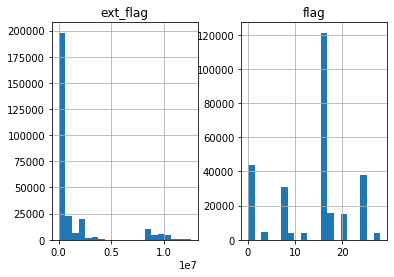

In [93]:
import matplotlib.pyplot as plt
game_data[game_data["label"]==0][complex_att_0x].hist(bins = 20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B6AB236048>,
      dtype=object)

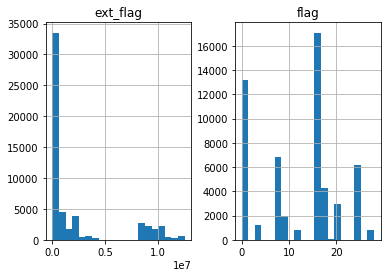

In [94]:
game_data[game_data["label"]==1][complex_att_0x].hist(bins = 20)